# Probability and Statistics

In some form or another, machine learning is all about making predictions.
We might want to predict the *probability* of a patient suffering a heart attack in the next year, given their clinical history. In anomaly detection, we might want to assess how *likely* a set of readings from an airplane's jet engine would be, were it operating normally. In reinforcement learning, we want an agent to act intelligently in an environment. This means we need to think about the probability of getting a high reward under each of the available action. And when we build recommender systems we also need to think about probability. For example, say *hypothetically* that we work for a large online bookseller. We might want to estimate the probability that a particular user would buy a particular book. For this we need to use the language of probability and statistics. Entire courses, majors, theses, careers, and even departments, are devoted to probability. So naturally, our goal in this section isn't to teach the whole subject. Instead we hope to get you off the ground, to teach you just enough that you can start building your first machine
learning models, and to give you enough of a flavor for the subject that you can begin to explore it on your own if you wish.


We've already invoked probabilities in previous sections without articulating what precisely they are or giving a concrete example. Let's get more serious now by considering the problem of distinguishing cats and dogs based on photographs. This might sound simple but it's actually a formidable challenge. To start with, the difficulty of the problem may depend on the resolution of the image.

| 10px | 20px | 40px | 80px | 160px |
|:----:|:----:|:----:|:----:|:-----:|
|![](../img/whitecat10.jpg)|![](../img/whitecat20.jpg)|![](../img/whitecat40.jpg)|![](../img/whitecat80.jpg)|![](../img/whitecat160.jpg)|
|![](../img/whitedog10.jpg)|![](../img/whitedog20.jpg)|![](../img/whitedog40.jpg)|![](../img/whitedog80.jpg)|![](../img/whitedog160.jpg)|

While it's easy for humans to recognize cats and dogs at 320 pixel resolution,
it becomes challenging at 40 pixels and next to impossible at 10 pixels. In
other words, our ability to tell cats and dogs apart at a large distance (and thus low resolution) might approach uninformed guessing. Probability gives us a
formal way of reasoning about our level of certainty. If we are completely sure
that the image depicts a cat, we say that the *probability* that the corresponding label $l$ is $\mathrm{cat}$, denoted $P(l=\mathrm{cat})$ equals
1.0. If we had no evidence to suggest that $l =\mathrm{cat}$ or that $l =
\mathrm{dog}$, then we might say that the two possibilities were equally
$likely$ expressing this as $P(l=\mathrm{cat}) = 0.5$. If we were reasonably
confident, but not sure that the image depicted a cat, we might assign a
probability $.5  < P(l=\mathrm{cat}) < 1.0$.

Now consider a second case: given some weather monitoring data, we want to predict the probability that it will rain in Taipei tomorrow. If it's summertime, the rain might come with probability $.5$. In both cases, we have some value of interest. And in both cases we are uncertain about the outcome.
But there's a key difference between the two cases. In this first case, the image is in fact either a dog or a cat, we just don't know which. In the second case, the outcome may actually be a random event, if you believe in such things (and most physicists do). So probability is a flexible language for reasoning about our level of certainty, and it can be applied effectively in a broad set of contexts.

## Basic probability theory

Say that we cast a die (掷赛子) and want to know what the chance is of seeing a $1$ rather than another digit. If the die is fair, all six outcomes $\mathcal{X} = \{1, \ldots, 6\}$ are equally likely to occur, and thus we would see a $1$ in $1$ out of $6$ cases. Formally we state that $1$ occurs with probability $\frac{1}{6}$.

For a real die that we receive from a factory, we might not know those proportions and we would need to check whether it is tainted. The only way to investigate the die is by casting it many times and recording the outcomes. For each cast of the die, we'll observe a value $\{1, 2, \ldots, 6\}$. Given these outcomes, we want to investigate the probability of observing each outcome.

One natural approach for each value is to take the
individual count for that value and to divide it by the total number of tosses.
This gives us an *estimate* of the probability of a given event. The law of
large numbers tell us that as the number of tosses grows this estimate will draw closer and closer to the true underlying probability. Before going into the details of what's going here, let's try it out.

To start, let's import the necessary packages:

In [2]:
import torch
from torch.distributions.multinomial import Multinomial

from IPython import display

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we'll want to be able to cast the die. In statistics we call this process
of drawing examples from probability distributions *sampling*.
The distribution
which assigns probabilities to a number of discrete choices is called the
*multinomial* distribution. We'll give a more formal definition of
*distribution* later, but at a high level, think of it as just an assignment of
probabilities to events. In PyTorch, we can sample from the multinomial
distribution via the aptly named `torch.distributions.multinomial.Multinomial` function which we have imported above. To draw a single
sample, we simply pass in a vector of probabilities.

In [3]:
# 首先声明每个的probability
probabilities = torch.ones([6], dtype = torch.float64) / 6
# total_count 进行probability投掷的次数，这样可以直接模拟多次投掷赛子的结果而不需要使用for循环
distribution = Multinomial(total_count = 1, probs = probabilities)
# 输出一个例子
distribution.sample()

tensor([0., 0., 1., 0., 0., 0.], dtype=torch.float64)

If you want to run the sampler a bunch of times, you can simply set `total_count` to some number. As with estimating the fairness of a die, we often want to
generate many samples from the same distribution. It would be unbearably slow to
do this with a Python `for` loop, so `torch.distributions.multinomial.Multinomial` supports drawing
multiple samples at once. ***For example if we set `total_count` to 100, we would get a tensor showing the number of times each face of the die appeared (sum of the tensor would be 100).***

In [4]:
print((Multinomial(total_count = 10, probs = probabilities)).sample()) #可以把输出的结果加起来正好等于10
print((Multinomial(total_count = 100, probs = probabilities)).sample())
print((Multinomial(total_count = 1000, probs = probabilities)).sample())

tensor([0., 1., 2., 2., 2., 3.], dtype=torch.float64)
tensor([16., 16., 16., 21., 15., 16.], dtype=torch.float64)
tensor([164., 169., 190., 146., 165., 166.], dtype=torch.float64)


Now that we know how to sample rolls of a die, we can simulate 1000 rolls. We
can then go through and count, after each of the 1000 rolls, how many times each
number was rolled.

In [5]:
num_rolls = 1000
rolls = Multinomial(total_count = 1, probs = probabilities)
counts = torch.zeros(6, 1000, dtype = torch.double)
totals = torch.zeros(6, dtype = torch.double)
# 按照列进行记录，每一列都是前面所有列按行的和
for i in range(num_rolls):
    totals = totals + rolls.sample()
    counts[:, i] = totals

To start, we can inspect the final tally at the end of $1000$ rolls.

In [6]:
totals / 1000

tensor([0.1670, 0.1750, 0.1760, 0.1600, 0.1550, 0.1670], dtype=torch.float64)

As you can see, the lowest estimated probability for any of the numbers is about $0.152$ and the highest estimated probability is $0.180$. Because we generated the data from a fair die, we know that each number actually has probability of $1/6$, roughly $0.167$, so these estimates are pretty good. We can also visualize how these probabilities converge over time towards reasonable estimates.

To start let's take a look at the `counts` array which has shape `(6, 1000)`.
For each time step (out of 1000), `counts` says how many times each of the numbers has shown up. So we can normalize each $j$-th column of the counts vector by the number of tosses to give the `current` estimated probabilities at that time. The counts object looks like this:

In [7]:
counts

tensor([[  0.,   1.,   2.,  ..., 167., 167., 167.],
        [  0.,   0.,   0.,  ..., 175., 175., 175.],
        [  1.,   1.,   1.,  ..., 176., 176., 176.],
        [  0.,   0.,   0.,  ..., 158., 159., 160.],
        [  0.,   0.,   0.,  ..., 155., 155., 155.],
        [  0.,   0.,   0.,  ..., 167., 167., 167.]], dtype=torch.float64)

Normalizing by the number of tosses, we get:

In [8]:
x = torch.arange(1000, dtype = torch.double).reshape((1,1000)) + 1
estimates = counts / x
print(estimates[:,0])
print(estimates[:,1])
print(estimates[:,100])

tensor([0., 0., 1., 0., 0., 0.], dtype=torch.float64)
tensor([0.5000, 0.0000, 0.5000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)
tensor([0.2178, 0.1386, 0.2178, 0.1683, 0.1089, 0.1485], dtype=torch.float64)


As you can see, after the first toss of the die, we get the extreme estimate
that one of the numbers will be rolled with probability $1.0$ and that the
others have probability $0$. After $100$ rolls, things already look a bit more
reasonable. We can visualize this convergence by using the plotting package
`matplotlib`. If you don't have it installed, now would be a good time to
[install it](https://matplotlib.org/).

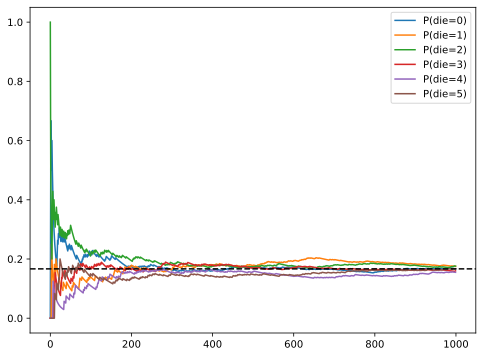

In [9]:
display.set_matplotlib_formats('svg')

plt.figure(figsize=(8, 6))
for i in range(6):
    plt.plot(estimates[i, :].numpy(), label=("P(die=" + str(i) +")"))

plt.axhline(y=0.16666, color='black', linestyle='dashed')
plt.legend()
plt.show()

# Each solid curve corresponds to one of the six values of the die and gives our estimated probability that the die turns up that value as assessed after each of the 1000 turns. The dashed black line gives the true underlying probability. As we get more data, the solid curves converge towards the true answer.

In our example of casting a die, we introduced the notion of a **random variable**. A random variable, which we denote here as $X$ can be pretty much any quantity and is not deterministic. Random variables could take one value among a set of possibilities. We denote sets with brackets, e.g., $\{\mathrm{cat}, \mathrm{dog}, \mathrm{rabbit}\}$. The items contained in the set are called *elements*, and we can say that an element $x$ is *in* the set S, by writing $x \in S$. The symbol $\in$ is read as "in" and denotes membership. For instance, we could truthfully say $\mathrm{dog} \in \{\mathrm{cat}, \mathrm{dog}, \mathrm{rabbit}\}$. When dealing with the rolls of die, we are concerned with a variable $X \in \{1, 2, 3, 4, 5, 6\}$.

Note that there is a subtle difference between discrete random variables, like the sides of a dice, and continuous ones, like the weight and the height of a person. There's little point in asking whether two people have exactly the same height. If we take precise enough measurements you'll find that no two people on the planet have the exact same height. In fact, if we take a fine enough measurement, you will not have the same height when you wake up and when you go to sleep. So there's no purpose in asking about the probability
that someone is $2.00139278291028719210196740527486202$ meters tall. Given the world population of humans the probability is virtually 0. It makes more sense in this case to ask whether someone's height falls into a given interval, say between 1.99 and 2.01 meters. In these cases we quantify the likelihood that we see a value as a *density*. The height of exactly 2.0 meters has no probability, but nonzero density. In the interval between any two different heights we have nonzero probability.


There are a few important axioms of probability that you'll want to remember:

* For any event $z$, the probability is never negative, i.e. $\Pr(Z=z) \geq 0$.
* For any two events $Z=z$ and $X=x$ the union is no more likely than the sum of the individual events, i.e. $\Pr(Z=z \cup X=x) \leq \Pr(Z=z) + \Pr(X=x)$.
* For any random variable, the probabilities of all the values it can take must sum to 1, i.e. $\sum_{i=1}^n \Pr(Z=z_i) = 1$.
* For any two *mutually exclusive* (互斥事件) events $Z=z$ and $X=x$, the probability that either happens is equal to the sum of their individual probabilities, that is $\Pr(Z=z \cup X=x) = \Pr(Z=z) + \Pr(X=x)$.

## Dealing with multiple random variables
Very often, we'll want to consider more than one random variable at a time.
For instance, we may want to model the relationship between diseases and symptoms. Given a disease and symptom, say 'flu' and 'cough', either may or may not occur in a patient with some probability. While we hope that the probability of both would be close to zero, we may want to estimate these probabilities and their relationships to each other so that we may apply our inferences to effect better medical care.

As a more complicated example, images contain millions of pixels, thus millions of random variables. And in many cases images will come with a
label, identifying objects in the image. We can also think of the label as a
random variable. We can even think of all the metadata as random variables
such as location, time, aperture, focal length, ISO, focus distance, camera type, etc. All of these are random variables that occur jointly. When we deal with multiple random variables, there are several quantities of interest. The first is called the joint distribution $\Pr(A, B)$. Given any elements $a$ and $b$, the joint distribution lets us answer, what is the probability that $A=a$ and $B=b$ simultaneously? Note that for any values $a$ and $b$, $\Pr(A=a,B=b) \leq \Pr(A=a)$.

This has to be the case, since for $A$ and $B$ to happen, $A$ has to happen *and* $B$ also has to happen (and vice versa). Thus $A,B$ cannot be more likely than $A$ or $B$ individually. This brings us to an interesting ratio: $0 \leq \frac{\Pr(A,B)}{\Pr(A)} \leq 1$. We call this a **conditional probability** (条件概率)
and denote it by $\Pr(B | A)$, the probability that $B$ happens, provided that
$A$ has happened. (在A发生的条件下，B发生的概率)

Using the definition of conditional probabilities, we can derive one of the most useful and celebrated equations in statistics—Bayes' theorem.
It goes as follows: By construction, we have that $\Pr(A, B) = \Pr(B | A) \Pr(A)$. By symmetry, this also holds for $\Pr(A,B) = \Pr(A | B) \Pr(B)$. Solving for one of the conditional variables we get:

$$\Pr(A | B) = \frac{\Pr(B | A) \Pr(A)}{\Pr(B)}$$

This is very useful if we want to infer one thing from another, say cause and effect but we only know the properties in the reverse direction. One important operation that we need, to make this work, is **marginalization**, i.e., the operation of determining $\Pr(A)$ and $\Pr(B)$ from $\Pr(A,B)$. We can see that the probability of seeing $A$ amounts to accounting for all possible choices of $B$ and aggregating the joint probabilities over all of them, i.e.

$$\Pr(A) = \sum_{B'} \Pr(A,B') \text{ and
} \Pr(B) = \sum_{A'} \Pr(A',B)$$

Another useful property to check for is **dependence** vs. **independence**.
Independence is when the occurrence of one event does not reveal any information about the occurrence of the other. (独立，一个事件完全与另一个事件无关) In this case $\Pr(B | A) = \Pr(B)$. Statisticians typically express this as $A \perp\!\!\!\perp B$. From Bayes' Theorem, it follows immediately that also $\Pr(A | B) = \Pr(A)$. In all other cases we call $A$ and $B$ dependent. For instance, two successive rolls of a die are independent. On the other hand, the position of a light switch and the brightness in the room are not (they are not perfectly deterministic, though, since we could always have a broken lightbulb, power failure, or a broken switch).

Let's put our skills to the test. Assume that a doctor administers an AIDS test to a patient. This test is fairly accurate and it fails only with 1% probability if the patient is healthy by reporting him as diseased. Moreover,
it never fails to detect HIV if the patient actually has it. We use $D$ to indicate the diagnosis and $H$ to denote the HIV status. ***D代表检测结果， H代表实际上HIV的状态*** Written as a table the outcome $\Pr(D | H)$ looks as follows:

|outcome| HIV positive | HIV negative |
|:------------|-------------:|-------------:|
|Test positive|            1 |         0.01 |
|Test negative|            0 |         0.99 |

Note that the column sums are all one (but the row sums aren't), since the conditional probability needs to sum up to $1$, just like the probability. Let us work out the probability of the patient having AIDS if the test comes back positive. Obviously this is going to depend on how common the disease is, since it affects the number of false alarms. Assume that the population is quite healthy, e.g. $\Pr(\text{HIV positive}) = 0.0015$. To apply Bayes' Theorem, we need to determine
$$\begin{aligned}
\Pr(\text{Test positive}) =& \Pr(D=1 | H=0) \Pr(H=0) + \Pr(D=1
| H=1) \Pr(H=1) \\
=& 0.01 \cdot 0.9985 + 1 \cdot 0.0015 \\
=& 0.011485
\end{aligned}
$$

Thus, we get

$$\begin{aligned} \Pr(H = 1 | D = 1) =& \frac{\Pr(D=1 | H=1) \Pr(H=1)}{\Pr(D=1)} \\ =& \frac{1 \cdot 0.0015}{0.011485} \\ =& 0.131 \end{aligned} $$

In other words, there's only a 13.1% chance that the patient actually has AIDS, despite using a test that is 99% accurate. As we can see, statistics can be quite counterintuitive.

## Conditional independence
What should a patient do upon receiving such terrifying news? Likely, he/she
would ask the physician to administer another test to get clarity. The second
test has different characteristics (it isn't as good as the first one).

|outcome |  HIV positive |  HIV negative |
|:------------|--------------:|--------------:|
|Test positive|          0.98 |          0.03 |
|Test negative|          0.02 |          0.97 |

Unfortunately, the second test comes back positive, too. Let us work out the requisite probabilities to invoke Bayes' Theorem.

* $\Pr(D_1 = 1 \text{ and } D_2 = 1 | H = 0) = 0.01 \cdot 0.03 = 0.0003$
* $\Pr(D_1 = 1 \text{ and } D_2 = 1 | H = 1) = 1 \cdot 0.98 = 0.98$
* $\Pr(D_1 = 1 \text{ and } D_2 = 1) = 0.0003 \cdot 0.9985 + 0.98 \cdot 0.0015 = 0.00176955$
* $\Pr(H = 1 | D_1 = 1 \text{ and } D_2 = 1) = \frac{0.98 \cdot 0.0015}{0.00176955} = 0.831$

That is, the second test allowed us to gain much higher confidence that not all is well. Despite the second test being considerably less accurate than the first one, it still improved our estimate quite a bit. You might ask, *why couldn't we just run the first test a second time?* After all, the first test was more accurate. The reason is that we needed a second test whose result is *independent* of the first test (given the true diagnosis). In other words, we made the tacit assumption that $\Pr(D_1, D_2 | H) = \Pr(D_1 | H) \Pr(D_2 | H)$. Statisticians call such random variables **conditionally independent**. This is expressed as $D_1 \perp\!\!\!\perp D_2  | H$.

## Sampling

Often, when working with probabilistic models, we'll want not just to estimate distributions from data, but also to generate data by sampling from distributions. One of the simplest ways to sample random numbers is to invoke the `random` method from Python's `random` package.

In [10]:
import random

for i in range(10):
    print(random.random())

0.7411133545363893
0.09437052071453988
0.4678049918316559
0.1354708041622904
0.4452703797626282
0.2128972293130338
0.6273944225692103
0.5028262989163732
0.7357316697097198
0.8715438408241963


### Uniform Distribution

These numbers likely *appear* random. Note that their range is between 0 and 1 and they are evenly distributed. Because these numbers are generated by default from the uniform distribution, there should be no two sub-intervals of $[0,1]$ of equal size where numbers are more likely to lie in one interval than the other. In other words, the chances of any of these numbers to fall into the interval $[0.2,0.3)$ are the same as in the interval $[.593264, .693264)$. In fact, these numbers are pseudo-random, and the computer generates them by first producing a random integer and then dividing it by its maximum range. To sample random integers directly, we can run the following snippet, which generates integers in the range between 1 and 100.

In [11]:
for i in range(10):
    print(random.randint(1, 100))

31
71
35
79
76
61
68
34
72
32


How might we check that ``randint`` is really uniform? Intuitively, the best
strategy would be to run sampler many times, say 1 million, and then count the
number of times it generates each value to ensure that the results are approximately uniform.

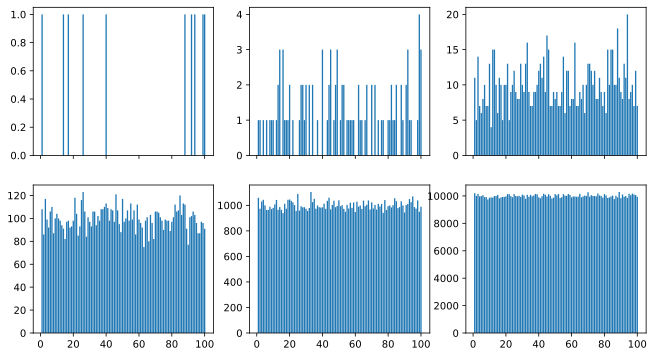

In [13]:
import math

counts = np.zeros(100)
fig, axes = plt.subplots(2, 3, figsize=(11, 6), sharex=True)
axes = axes.reshape(6)

# Mangle subplots such that we can index them in a linear fashion rather than
# a 2D grid

for i in range(1, 1000001):
    counts[random.randint(0, 99)] += 1
    if i in [10, 100, 1000, 10000, 100000, 1000000]:
        axes[int(math.log10(i))-1].bar(np.arange(1, 101), counts)
plt.show()

We can see from these figures that the initial number of counts looks *strikingly* uneven. If we sample fewer than 100 draws from a distribution over
100 outcomes this should be expected. But even for 1000 samples there is a
significant variability between the draws. What we are really aiming for is a
situation where the probability of drawing a number $x$ is given by $p(x)$.

### The categorical distribution

Drawing from a uniform distribution over a set of 100 outcomes is simple. But what if we have nonuniform probabilities? Let's start with a simple case, a biased coin which comes up heads with probability 0.35 and tails with probability 0.65. A simple way to sample from that is to generate a uniform random variable over $[0,1]$ and if the number is less than $0.35$, we output heads and otherwise we generate tails. Let's try this out.

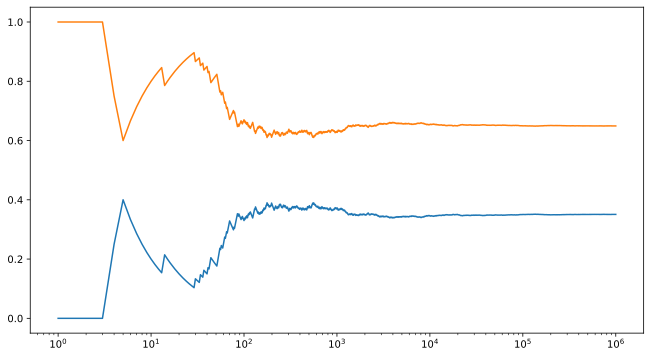

In [14]:
# Number of samples
n = 1000000
y = np.random.uniform(0, 1, n)
x = np.arange(1, n+1)
# Count number of occurrences and divide by the number of total draws
p0 = np.cumsum(y < 0.35) / x
p1 = np.cumsum(y >= 0.35) / x

plt.figure(figsize=(11, 6))
plt.semilogx(x, p0)
plt.semilogx(x, p1)
plt.show()

As we can see, on average, this sampler will generate 35% zeros and 65% ones.
Now what if we have more than two possible outcomes? We can simply generalize
this idea as follows. Given any probability distribution, e.g. $p = [0.1, 0.2, 0.05, 0.3, 0.25, 0.1]$ we can compute its cumulative distribution (python's ``cumsum`` will do this for you) $F = [0.1, 0.3, 0.35, 0.65, 0.9, 1]$. Once we have this we draw a random variable $x$ from the uniform distribution $U[0,1]$ and then find the interval where $F[i-1] \leq x < F[i]$. We then return $i$ as the sample. By construction, the chances of hitting interval $[F[i-1], F[i])$ has probability $p(i)$.

Note that there are many more efficient algorithms for sampling than the one above. For instance, binary search over $F$ will run in $O(\log n)$ time for $n$ random variables. There are even more clever algorithms, such as the [Alias
Method](https://en.wikipedia.org/wiki/Alias_method) to sample in constant time,
after $O(n)$ preprocessing.

### The Normal distribution

The standard Normal distribution (aka the standard Gaussian distribution) is given by $p(x) = \frac{1}{\sqrt{2 \pi}} \exp\left(-\frac{1}{2} x^2\right)$. Let's plot it to get a feel for it.

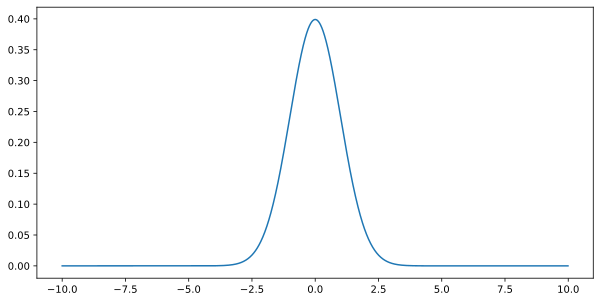

In [15]:
x = np.arange(-10, 10, 0.01)
p = (1/math.sqrt(2 * math.pi)) * np.exp(-0.5 * x**2)
plt.figure(figsize=(10, 5))
plt.plot(x, p)
plt.show()

Sampling from this distribution is less trivial. First off, the support is
infinite, that is, for any $x$ the density $p(x)$ is positive. Secondly, the
density is nonuniform. There are many tricks for sampling from it - the key idea in all algorithms is to stratify $p(x)$ in such a way as to map it to the
uniform distribution $U[0,1]$. One way to do this is with the probability
integral transform.

Denote by $F(x) = \int_{-\infty}^x p(z) dz$ the cumulative distribution function (CDF) of $p$. This is in a way the continuous version of the cumulative sum that we used previously. In the same way we can now define the inverse map $F^{-1}(\xi)$, where $\xi$ is drawn uniformly. Unlike previously where we needed to find the correct interval for the vector $F$ (i.e. for the piecewise constant function), we now invert the function $F(x)$.

In practice, this is slightly more tricky since inverting the CDF is hard in the case of a Gaussian. It turns out that the *twodimensional* integral is much easier to deal with, thus yielding two normal random variables than one, albeit at the price of two uniformly distributed ones. For now, suffice it to say that there are built-in algorithms to address this.

The normal distribution has yet another desirable property. In a way all distributions converge to it, if we only average over a sufficiently large number of draws from any other distribution. To understand this in a bit more detail, we need to introduce three important things: expected values, means and variances.

* The expected value $\mathbf{E}_{x \sim p(x)}[f(x)]$ of a function $f$ under a distribution $p$ is given by the integral $\int_x p(x) f(x) dx$. That is, we average over all possible outcomes, as given by $p$.
* A particularly important expected value is
that for the function $f(x) = x$, i.e. $\mu := \mathbf{E}_{x \sim p(x)}[x]$. It
provides us with some idea about the typical values of $x$.
* Another important quantity is the variance, i.e. the typical deviation from the mean $\sigma^2 := \mathbf{E}_{x \sim p(x)}[(x-\mu)^2]$. Simple math shows (check it as an exercise) that $\sigma^2 = \mathbf{E}_{x \sim p(x)}[x^2] - \mathbf{E}^2_{x \sim p(x)}[x]$.

The above allows us to change both mean and variance of random variables. Quite obviously for some random variable $x$ with mean $\mu$, the random variable $x + c$ has mean $\mu + c$. Moreover, $\gamma x$ has the variance $\gamma^2 \sigma^2$. Applying this to the normal distribution we see that one with mean $\mu$ and variance $\sigma^2$ has the form $p(x) = \frac{1}{\sqrt{2 \sigma^2 \pi}} \exp\left(-\frac{1}{2 \sigma^2} (x-\mu)^2\right)$. Note the scaling factor $\frac{1}{\sigma}$—it arises from the fact that if we stretch the distribution by $\sigma$, we need to lower it by $\frac{1}{\sigma}$ to retain the same probability mass (i.e. the weight under the distribution always needs to integrate out to 1).

Now we are ready to state one of the most fundamental theorems in statistics, the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). It states that for sufficiently well-behaved random variables, in particular random variables with well-defined mean and variance, the sum tends toward a normal distribution. To get some idea, let's repeat the experiment described in the beginning, but now using random variables with integer values of $\{0, 1, 2\}$.

mean 0.9, variance 0.49


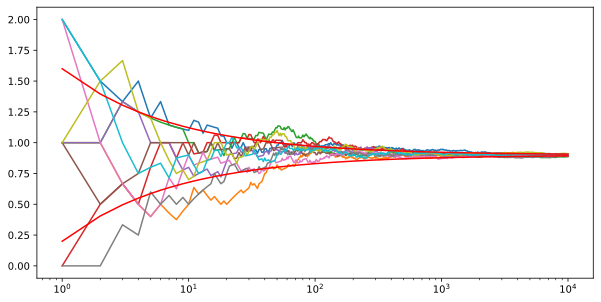

In [16]:
# Generate 10 random sequences of 10,000 uniformly distributed random variables
tmp = np.random.uniform(size=(10000,10))
x = 1.0 * (tmp > 0.3) + 1.0 * (tmp > 0.8)
mean = 1 * 0.5 + 2 * 0.2
variance = 1 * 0.5 + 4 * 0.2 - mean**2
print('mean {}, variance {}'.format(mean, variance))

# Cumulative sum and normalization
y = np.arange(1,10001).reshape(10000,1)
z = np.cumsum(x,axis=0) / y

plt.figure(figsize=(10,5))
for i in range(10):
    plt.semilogx(y,z[:,i])

plt.semilogx(y,(variance**0.5) * np.power(y,-0.5) + mean,'r')
plt.semilogx(y,-(variance**0.5) * np.power(y,-0.5) + mean,'r')
plt.show()

This looks very similar to the initial example, at least in the limit of averages of large numbers of variables. This is confirmed by theory. Denote by
mean and variance of a random variable the quantities

$$\mu[p] := \mathbf{E}_{x \sim p(x)}[x] \text{ and } \sigma^2[p] := \mathbf{E}_{x \sim p(x)}[(x - \mu[p])^2]$$

Then we have that $\lim_{n\to \infty} \frac{1}{\sqrt{n}} \sum_{i=1}^n \frac{x_i - \mu}{\sigma} \to \mathcal{N}(0, 1)$. In other words, regardless of what we started out with, we will always converge to a Gaussian. This is one of the reasons why Gaussians are so popular in statistics.


### More distributions

Many more useful distributions exist. If you're interested in going deeper, we recommend consulting a dedicated book on statistics or looking up some common distributions on Wikipedia for further detail. Some important distirbutions to be aware of include:

* **Binomial Distribution** It is used to describe the distribution over multiple draws from the same distribution, e.g. the number of heads when tossing a biased coin (i.e. a coin with probability $\pi \in [0, 1]$ of returning heads) 10 times. The binomial probability is given by $p(x) = {n \choose x} \pi^x (1-\pi)^{n-x}$.
* **Multinomial Distribution** Often, we are concerned with more than two
outcomes, e.g. when rolling a dice multiple times. In this case, the
distribution is given by $p(x) = \frac{n!}{\prod_{i=1}^k x_i!} \prod_{i=1}^k \pi_i^{x_i}$.
* **Poisson Distribution** This distribution models the occurrence of point events that happen with a given rate, e.g. the number of raindrops arriving within a given amount of time in an area (weird fact - the number of Prussian soldiers being killed by horses kicking them followed that distribution). Given a rate $\lambda$, the number of occurrences is given by $p(x) = \frac{1}{x!} \lambda^x e^{-\lambda}$.
* **Beta, Dirichlet, Gamma, and Wishart Distributions** They are what statisticians call *conjugate* to the Binomial, Multinomial, Poisson and Gaussian respectively. Without going into detail, these distributions are often used as priors for coefficients of the latter set of distributions, e.g. a Beta distribution as a prior for modeling the probability for binomial outcomes.



## Summary

So far, we covered probabilities, independence, conditional independence, and how to use this to draw some basic conclusions. We also introduced some fundamental probability distributions and demonstrated how to sample from them using PyTorch. This is already a powerful bit of knowledge, and by itself a sufficient set of tools for developing some classic machine learning models. In the next section, we will see how to operationalize this knowlege to build your first machine learning model: the Naive Bayes classifier.

## Exercises

1. Given two events with probability $\Pr(A)$ and $\Pr(B)$, compute upper and lower bounds on $\Pr(A \cup B)$ and $\Pr(A \cap B)$. Hint - display the situation using a [Venn Diagram](https://en.wikipedia.org/wiki/Venn_diagram).
1. Assume that we have a sequence of events, say $A$, $B$ and $C$, where $B$ only depends on $A$ and $C$ only on $B$, can you simplify the joint probability? Hint - this is a [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain).